In [1]:
from pathlib import Path
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
from tools import *

In [2]:
download_base = Path('./data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

path  = abc_cache.get_data_path(directory='Zeng-Aging-Mouse-10Xv3', file_name='Zeng-Aging-Mouse-10Xv3/log2')
adata = sc.read_h5ad(path)

In [3]:
# load metadata
cell = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-10Xv3',
    file_name='cell_metadata',
    dtype={'cell_label': str,
           'wmb_cluster_alias': 'Int64'}
)
cell.set_index('cell_label', inplace=True)

In [4]:
# load metadata
cluster_info = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-10Xv3',
    file_name='cluster'
).set_index('cluster_alias')
# Join the cluster information in by joining on the Aging dataset's cluster_alias column.
cell_extended = cell.join(cluster_info, on='cluster_alias', rsuffix='_cl_info')
cell_cluster_mapping = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-WMB-taxonomy',
    file_name='cell_cluster_mapping_annotations'
).set_index('cell_label')
cell_extended = cell_extended.join(cell_cluster_mapping, rsuffix='_cl_map')
# Quick run through to drop duplicated columns
drop_cols = []
for col in cell_extended.columns:
    if col.endswith(('_cl_map', '_cl_colors', '_cl_info')):
        drop_cols.append(col)
cell_extended.drop(columns=drop_cols, inplace=True)

In [5]:
# load all degenes
degenes = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-WMB-taxonomy',
    file_name='aging_degenes'
)

In [6]:
# get the subclass names
subclass_names = cell_extended['subclass_name'].unique()

In [7]:
# target subclasses with different number of degene counts
age_DE_high_subclass = ['L4 RSP-ACA Glut', 'TU-ARH Otp Six6 Gaba', 'PVH-SO-PVa Otp Glut', 'PRP-NI-PRNc-GRN Otp Glut']
age_DE_medium_subclass = ['STR D1 Gaba', 'DG Glut', 'OB-STR-CTX Inh IMN', 'DMH-LHA Gsx1 Gaba', 'PG-TRN-LRN Fat2 Glut']
age_DE_low_subclass = ['Vip Gaba', 'MPO-ADP Lhx8 Gaba', 'PH-an Pitx2 Glut', 'ND-INC Foxd2 Glut', 'NTS Dbh Glut']

aged_high = name_with_index(age_DE_high_subclass, subclass_names)
aged_medium = name_with_index(age_DE_medium_subclass, subclass_names)
aged_low = name_with_index(age_DE_low_subclass, subclass_names)

In [8]:
# define regression functions
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.api as sm


def select_important_feature_logistic(X, y, C=1e-3):

    X_with_intercept = sm.add_constant(X)
    lasso_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=C)

    lasso_logreg.fit(X_with_intercept, y)

    important_features = np.where(lasso_logreg.coef_[0] != 0)[0]

    y_pred = lasso_logreg.predict(X_with_intercept)
    acc = accuracy_score(y, y_pred)

    return lasso_logreg, important_features, acc


def regression_on_pca(adata, 
                      metadata,
                      regression_terms=['donor_age_category'],
                      C=1e-3): 
    
    adata = assign_binary_regression_labels(adata, metadata, regression_terms)
    X = adata.obsm['X_pca']
    X_with_intercept = sm.add_constant(X)
    y = adata.obs['regression_labels']

    lasso_logreg, important_features, acc = select_important_feature_logistic(X_with_intercept, y, C=C)
    return adata, lasso_logreg, important_features, acc

In [56]:
# define function to evaluate importance of features
import shap

def shap_importance_analysis(lasso_logreg, adata, max_display=10):
    # Create a SHAP explainer
    X = adata.obsm['X_pca']
    X_with_intercept = sm.add_constant(X)
    explainer = shap.LinearExplainer(lasso_logreg, X_with_intercept)

    feature_names = ['PC{}'.format(i+1) for i in range(X.shape[1])]
    feature_names = ['intercept'] + feature_names

    # Get SHAP values for the training data
    shap_values = explainer.shap_values(X_with_intercept)

    # Plot summary of SHAP values (global feature importance)
    shap.summary_plot(shap_values, X_with_intercept, feature_names=feature_names, max_display=max_display)
    return shap_values

In [57]:
import matplotlib.pyplot as plt

# define function to plot the degene-detected results
def plot_degene_trend(n_selected_features, 
                      degenes_detected_among_all, 
                      degenes_detected_among_extracted, 
                      acc,
                      subclass_type):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(range(1, n_selected_features+1), degenes_detected_among_all, label='# DE genes / all DE genes')
    ax.plot(range(1, n_selected_features+1), degenes_detected_among_extracted, label='# DE genes / selected genes')
    ax.set_xlabel('Number of features selected')
    ax.set_ylabel('Genes detected ratio')
    ax.set_ylim(0, 1.05)
    ax.legend()
    ax.set_title(f"{subclass_type}, Classification accuracy: {acc:.2f}")
    plt.tight_layout()
    plt.show()
    

In [58]:
# detect degenes by subclass

subclass_name = aged_high[0]
degenes_subclass = degenes[degenes['grouping_name'] == subclass_name]
subclass_adata, subclass_cells = filter_cells_by_anaotation(adata, cell_extended, 'subclass_name', subclass_name)
subclass_adata = filter_genes_by_expression(subclass_adata)
sc.tl.pca(subclass_adata, n_comps=50)

/opt/anaconda3/envs/rna/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [59]:
C = 1e-3
subclass_adata, lasso_logreg, important_features, acc = regression_on_pca(
                        subclass_adata, subclass_cells, regression_terms=['donor_age_category'], C=C
                        )
print(f"Classification accuracy for {subclass_name}: {acc}")
print(f"Number of selected features: {len(important_features)}")

Classification accuracy for 021 L4 RSP-ACA Glut: 0.976231884057971
Number of selected features: 6


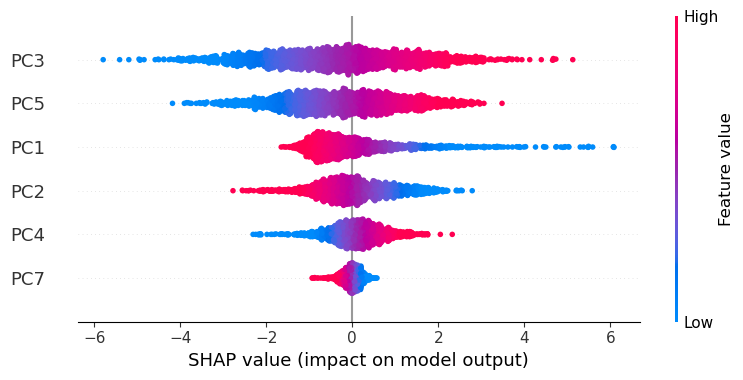

In [60]:
n_selected_features = len(important_features)
shap_values = shap_importance_analysis(lasso_logreg, subclass_adata, max_display=n_selected_features)
sorted_indices = order_loadings_by_shap(shap_values)
selected_features = sorted_indices[:n_selected_features]
loading_idx = [i-1 for i in selected_features]

In [61]:
n_genes_per_pc=200
degenes_detected_among_all, degenes_detected_among_extracted = detect_degenes_accumulated(
                        subclass_adata, loading_idx, degenes_subclass['gene_symbol'], n_genes_per_pc=n_genes_per_pc
                        )

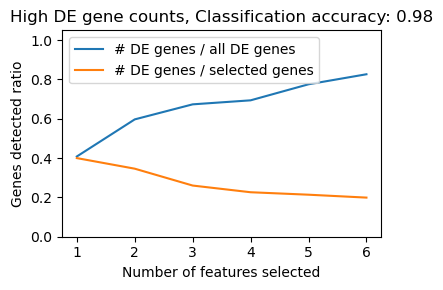

In [62]:
plot_degene_trend(n_selected_features, degenes_detected_among_all, degenes_detected_among_extracted, acc, 'High DE gene counts')

In [63]:
# detect degenes by subclass

subclass_name = aged_medium[0]
degenes_subclass = degenes[degenes['grouping_name'] == subclass_name]
subclass_adata, subclass_cells = filter_cells_by_anaotation(adata, cell_extended, 'subclass_name', subclass_name)
subclass_adata = filter_genes_by_expression(subclass_adata)
sc.tl.pca(subclass_adata, n_comps=50)

/opt/anaconda3/envs/rna/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [64]:
C = 5e-5
subclass_adata, lasso_logreg, important_features, acc = regression_on_pca(
                            subclass_adata, subclass_cells, regression_terms=['donor_age_category'], C=C
                            )
print(f"Classification accuracy for {subclass_name}: {acc}")
print(f"Number of selected features: {len(important_features)}")

Classification accuracy for 061 STR D1 Gaba: 0.8046903627702455
Number of selected features: 8


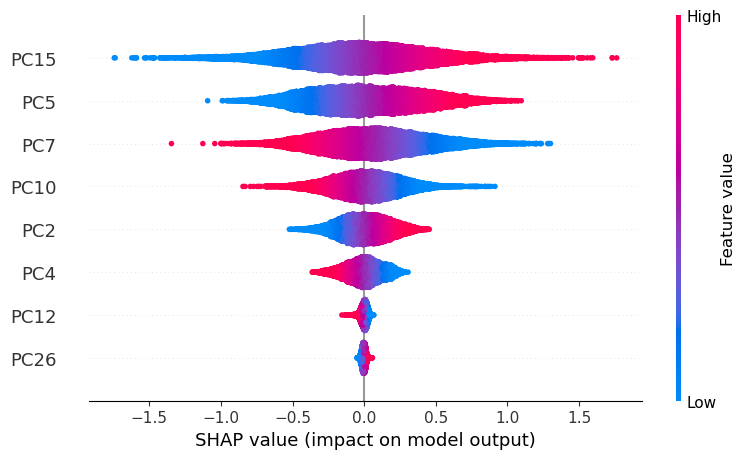

In [65]:
n_selected_features = len(important_features)
shap_values = shap_importance_analysis(lasso_logreg, subclass_adata, max_display=n_selected_features)
sorted_indices = order_loadings_by_shap(shap_values)
selected_features = sorted_indices[:n_selected_features]
loading_idx = [i-1 for i in selected_features]

In [66]:
n_genes_per_pc=200
degenes_detected_among_all, degenes_detected_among_extracted = detect_degenes_accumulated(
                            subclass_adata, loading_idx, degenes_subclass['gene_symbol'], n_genes_per_pc=n_genes_per_pc
                            )

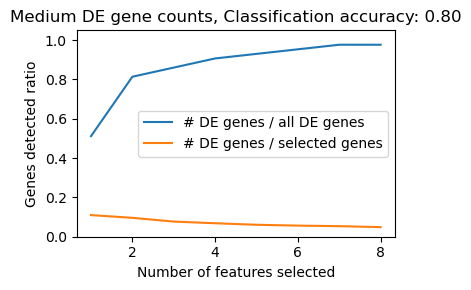

In [67]:
plot_degene_trend(n_selected_features, degenes_detected_among_all, degenes_detected_among_extracted, acc, 'Medium DE gene counts')

In [68]:
# detect degenes by subclass

subclass_name = aged_low[0]
degenes_subclass = degenes[degenes['grouping_name'] == subclass_name]
subclass_adata, subclass_cells = filter_cells_by_anaotation(adata, cell_extended, 'subclass_name', subclass_name)
subclass_adata = filter_genes_by_expression(subclass_adata)
sc.tl.pca(subclass_adata, n_comps=50)

/opt/anaconda3/envs/rna/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [69]:
C = 2e-4
subclass_adata, lasso_logreg, important_features, acc = regression_on_pca(
                            subclass_adata, subclass_cells, regression_terms=['donor_age_category'], C=C
                            )
print(f"Classification accuracy for {subclass_name}: {acc}")
print(f"Number of selected features: {len(important_features)}")

Classification accuracy for 046 Vip Gaba: 0.8334600760456273
Number of selected features: 7


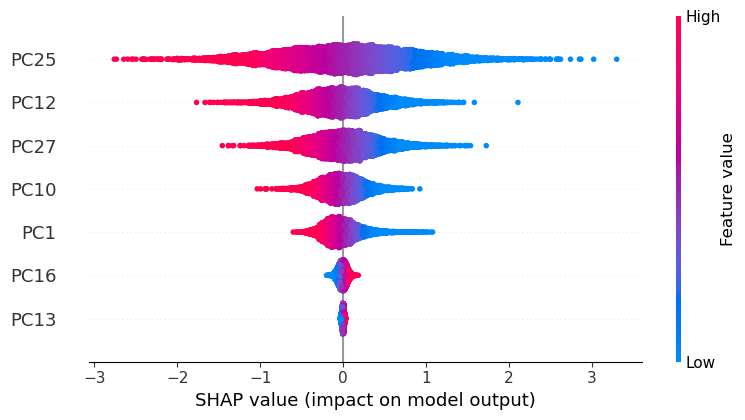

In [70]:
n_selected_features = len(important_features)
shap_values = shap_importance_analysis(lasso_logreg, subclass_adata, max_display=n_selected_features)
sorted_indices = order_loadings_by_shap(shap_values)
selected_features = sorted_indices[:n_selected_features]
loading_idx = [i-1 for i in selected_features]

In [71]:
n_genes_per_pc=200
degenes_detected_among_all, degenes_detected_among_extracted = detect_degenes_accumulated(
                            subclass_adata, loading_idx, degenes_subclass['gene_symbol'], n_genes_per_pc=n_genes_per_pc
                            )

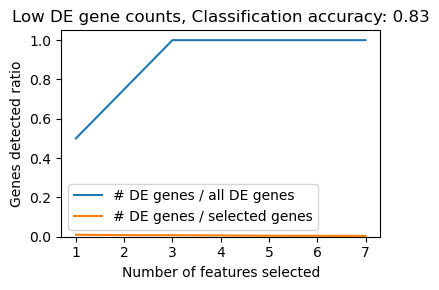

In [72]:
plot_degene_trend(n_selected_features, degenes_detected_among_all, degenes_detected_among_extracted, acc, 'Low DE gene counts')